In [380]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import sin
from math import cos
from math import pi
import pandas as pd
from scipy.optimize import curve_fit
from decimal import Decimal
import math

In [382]:
def twoDRocket_ODE(state_vectors, t, g, m, IG, a, alpha, rho, S, Cl, Cd, ThrustFit):
    # state_vectors = [x, y, V_x, V_y, theta, thetaDot]
    # t             = time vector (s)
    # g             = Gravitational Acceleration m/s^2
    # m             = Mass of the Rocket in kg
    # IG            = Moment of Inertia of the Rocket in kg*m^2
    # a             = Distance between the ceneter of pressure and center of gravity
    # alpha         = Angle of Attack
    # rho           = Air Density
    # S             = Relevant Area for Drag and Lift Force Calculation    
    # Cl            = Lift Coefficient
    # Cd            = Drag Coefficient    
    
    ####################################################
    
    ## Relevant Forces
    # T  = Thrust from Motor in Newtons
    # v  = velocity in body frame or velocity magnitude m/s
    # M  = Mach Number: speed of the object/ speed of the sound in the medium
    # L  = Lift in N (its direction is perpendicular to the veocity vector)
    # D  = Drag in N (its direction is parallel to the velocity vector)
    # Fx = Horizontal force acting on the rocket in body frame in N
    # Fy = Vertical force acting on the rocket in body frame in N
    T  =  0 # ADD THRUST EQUATION
    v  = math.sqrt(pow(state_vectors[2],2)+pow(state_vectors[3],2))
    M  = v/351.81
    if M <= 0.6:
        Cd = 0.2083333*pow(M,2) - 0.25*M+0.46
    elif M > 0.6 and M <= 0.8:
        Cd = 1.25*pow(M,3) - 2.125*pow(M,2) + 1.2*M + 0.16
    elif M > 0.8 and M <= 0.95:
        Cd = 10.37037*pow(M,3) - 22.88889*pow(M,2) + 16.91111*M - 3.78963
    elif M > 0.95 and M <= 1.05:
        Cd =-30*pow(M,3) + 88.5*pow(M,2) - 85.425*M + 27.51375
        
    L  = 0.5*rho*pow(v,2)*S*Cl
    D  = 0.5*rho*pow(v,2)*S*Cd 
    Fx = T + L*sin(alpha) - D*cos(alpha)
    Fy = L*cos(alpha) + D*sin(alpha)
    
    ####################################################
    
    ## ODE
    dxdt = state_vectors[2]
    dydt = state_vectors[3]
    dvxdt = (Fx*cos(state_vectors[4]) - Fy*sin(state_vectors[4]))/m
    if state_vectors[1] == 0:
        dvydt = 0
    else :
        dvydt = (Fx*sin(state_vectors[4]) + Fy*cos(state_vectors[4])-m*g)/m
    dthetadt = state_vectors[5]
    dthetaDotdt = (-L*a*cos(alpha) - D*a*sin(alpha))/IG
    return [dxdt, dydt, dvxdt, dvydt, dthetadt, dthetaDotdt]

<Axes: title={'center': 'B6 Motor Thrust Curve by John Coker'}, xlabel='Time (s)', ylabel='Thrust (N)'>

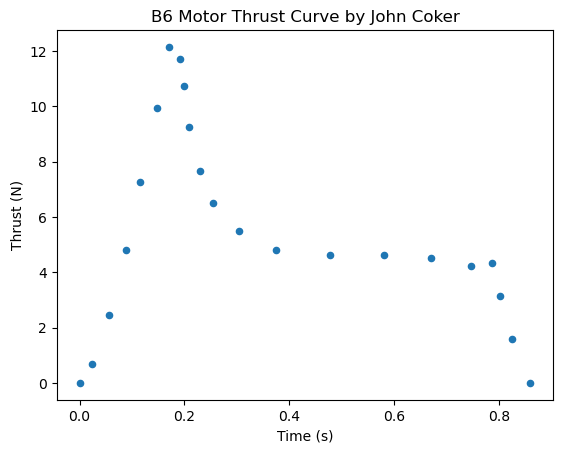

In [384]:
## Thrust Curve
ThrustData = pd.read_csv(r'C:\Users\bktf3\Desktop\rocket\simulation\B6motorThrustDatabyJohnCoker.csv', skiprows=3)
ThrustData.set_index('Time (s)')
ThrustData.plot.scatter(title = 'B6 Motor Thrust Curve by John Coker', x = 'Time (s)', y = 'Thrust (N)', xlabel = ('Time (s)'), ylabel = ('Thrust (N)')) 

C:\Users\bktf3\AppData\Local\Temp\ipykernel_18988\1524238768.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  constants       = curve_fit(linear, ThrustData[i:i+2,0], ThrustData[i:i+2,1])


Text(0, 0.5, 'Thrust (N)')

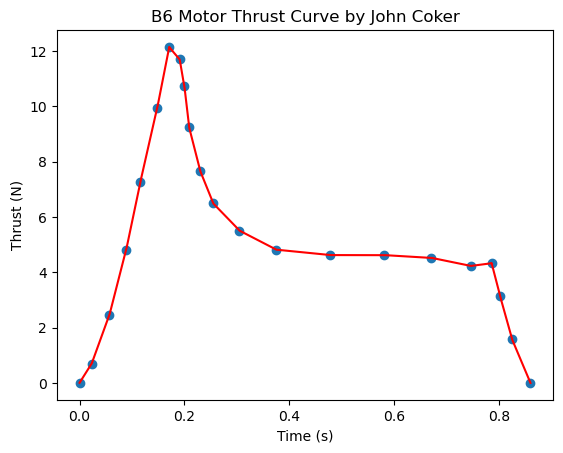

In [385]:
# ## Curve Fit Thrust Curve
ThrustData = pd.DataFrame(ThrustData).to_numpy()
fit = []
curvetime = []
# Type of curve I am going to be fitting for the thrust curve
def linear(x, a,b):
    return a*x + b  
for i in range(0,len(ThrustData)-1):
    timeForCurveFit = np.arange(ThrustData[i,0],ThrustData[i+1,0]+tstep,tstep)
    constants       = curve_fit(linear, ThrustData[i:i+2,0], ThrustData[i:i+2,1])
    a = constants[0][0]
    b = constants[0][1]
    for j in timeForCurveFit:
        fit.append(linear(j, a,b))
        curvetime.append(j)
fit = np.array(fit)
curvetime = np.array(curvetime)

plt.scatter(ThrustData[:,0],ThrustData[:,1])
plt.plot(curvetime,fit, color ='red')
plt.title('B6 Motor Thrust Curve by John Coker')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')

In [392]:
## Define Parameters
# state_vectors = [x, y, V_x, V_y, theta, thetaDot]
# x0            = initial states
# tstep         = step size for time vector t in seconds
# t             = time vector (s)
# g             = Gravitational Acceleration m/s^2
# m             = Mass of the Rocket in kg
# IG            = Moment of Inertia of the Rocket in kg*m^2
# a             = Distance between the center of pressure and center of gravity in m
# alpha         = Angle of Attack in radians
# rho           = Air Density in kg/m^3
# S             = Relevant Area for Drag and Lift Force Calculation in m^2  
# Cl            = Lift Coefficient
# Cd            = Drag Coefficient   
# cp            = Center of Pressure location from the nose
# cg            = Center of Gravity from the nose
x0    = [0,0,0,0,0,0]
tstep = 0.0001 # s
t     = np.arange(0,10,tstep)
g     = 9.81 # m/s^2
m     = 0.124 # kg
IG    = 0.007177656 # kg*m^2
cp    = 0.626 # m
cg    = 0.452 # m
a     = abs(cp-cg)
alpha = 0
rho   = 1.225 # kg/m^3 at sea level Temporary value. Change it according to the day I launch it.
S     = 1/4*pi*pow(0.035,2) # m^2
Cl    = 16.85
Cd    = 0 # Cd is calculated again in the ODE function. This varies with speed.
solution = odeint(twoDRocket_ODE, x0, t, args = (g, m, IG, a, alpha, rho, S, Cl, Cd, fit))

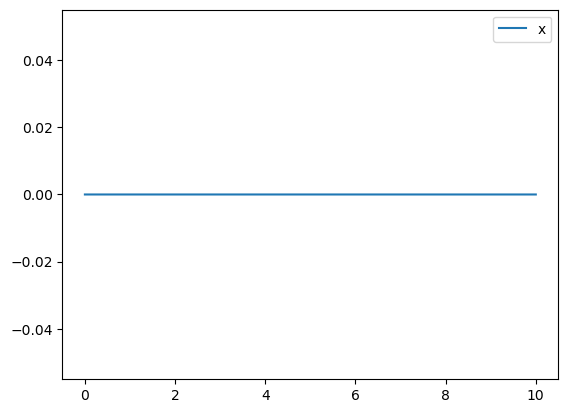

In [394]:
plt.plot(t,solution[:,0])

plt.legend(['x'])

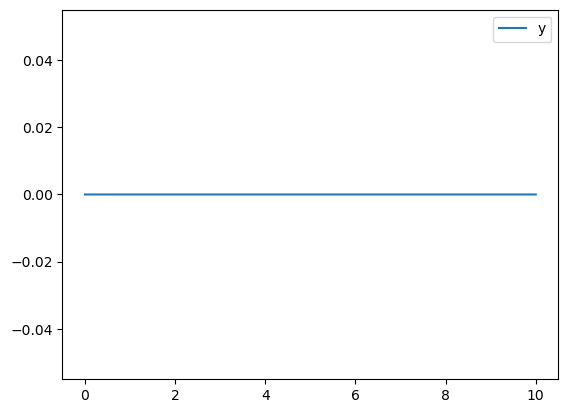

In [396]:
plt.plot(t,solution[:,1])
plt.legend('y')

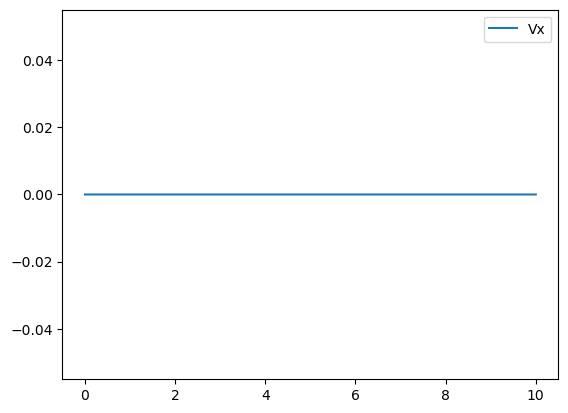

In [398]:
plt.plot(t,solution[:,2])
plt.legend(['Vx'])

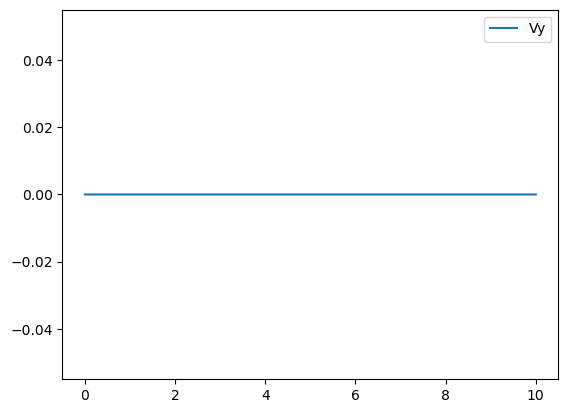

In [399]:
plt.plot(t,solution[:,3])
plt.legend(['Vy'])

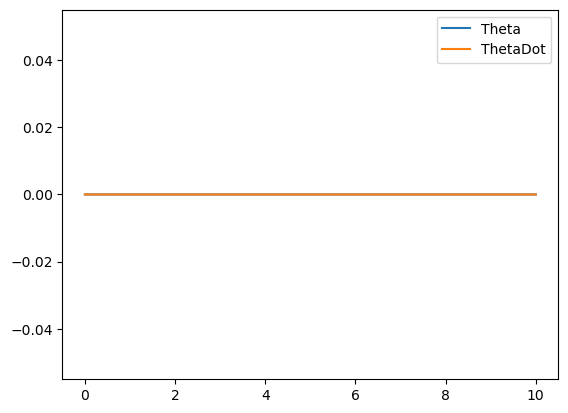

In [401]:
plt.plot(t,solution[:,4])
plt.plot(t,solution[:,5])
plt.legend(['Theta','ThetaDot'])

In [374]:
solution.shape

(100000, 7)

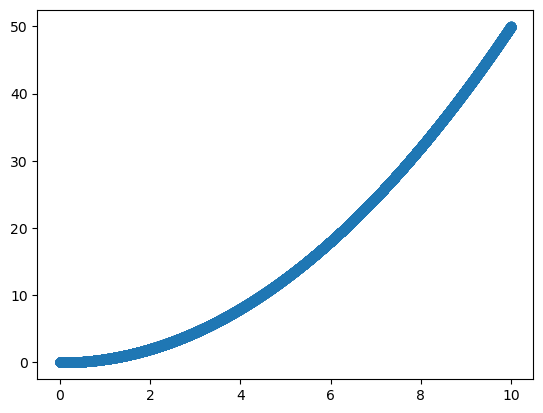

In [378]:
plt.scatter(t,solution[:,6])
